# Get HP and LP case scenarios

See bottom part of the `README.md` for motivation. We want to get the HP and LP data points to selectively train ML models. In other commits, I used "best" and "worst" to describe this process, but those are not the best terms to be using for this so instead I changed it to HP and LP.  Really, it's more like "data that are most likely to expand the horizons of an ML model" and "data that are most likely to reinforce the existing understanding of the ML model".



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
avg_df = pd.read_csv('post_01_output_ml_predict_avg.csv-Nov-2023-log10-DO-update-correct')
std_df = pd.read_csv('post_01_output_ml_predict_std.csv-Nov-2023-log10-DO-update-correct')

# Use Sample_ID as the index so files can be merged on this value
avg_df.set_index('Sample_ID',inplace=True)
std_df.set_index('Sample_ID',inplace=True)

# We want to get only the SSS, S19S, and CM_ sites. But for now, it's easier to just merge
# everything and compute everything.
all_df = pd.merge(
        avg_df,
        std_df, 
        left_index=True,
        right_index=True,
        suffixes=['_avg','_std'])

# Compute the metric combining the average PCA distance and the ensemble spread uncertainty as an error estimate.
# The "best" sites are those with high PCA distance and high uncertainty.
# The "worst" sites are those with low PCA distance and low uncertainty.
all_df['best_worst_metric'] = (all_df['pca.dist_avg']/all_df['pca.dist_avg'].max()) * (all_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std']/all_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std'].max())

In [3]:
# Display some values to cross check
all_df

,Sample_Longitude_avg,Sample_Latitude_avg,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_avg,mean.error_avg,predict.error_avg,pca.dist_avg,mean.error.scaled_avg,pca.dist.scaled_avg,combined.metric_avg,Sample_Longitude_std,Sample_Latitude_std,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std,mean.error_std,predict.error_std,pca.dist_std,mean.error.scaled_std,pca.dist.scaled_std,combined.metric_std,best_worst_metric
Sample_ID,,,,,,,,,,,,,,,,,,,
100001,-67.927361,47.160181,-203.193094,74.335300,934.617882,1.250399,0.173833,0.088274,0.015345,0.0,0.0,241.124361,17.760051,210.369212,0.0,0.055002,0.0,0.004855,0.007929
100002,-68.002459,46.847909,-338.189003,82.809223,935.696389,1.678210,0.191350,0.118476,0.022670,0.0,0.0,470.403527,39.815757,211.573619,0.0,0.085986,0.0,0.010187,0.020761
100003,-67.831939,46.773619,-325.986061,83.260482,935.767619,1.819086,0.191842,0.128421,0.024636,0.0,0.0,483.035175,41.090945,211.664164,0.0,0.087287,0.0,0.011210,0.023108
100004,-67.298037,45.168718,-130.951314,73.819376,934.576007,1.081908,0.173068,0.076379,0.013219,0.0,0.0,36.330123,17.293418,210.335180,0.0,0.055464,0.0,0.004236,0.001034
100005,-67.935542,44.606084,-65.588434,75.522781,934.712317,0.564578,0.177505,0.039857,0.007075,0.0,0.0,27.570025,17.301685,210.334771,0.0,0.057805,0.0,0.002304,0.000409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SSS047-2,-120.921300,47.185700,-151.828457,73.257573,934.531438,2.254710,0.171683,0.159174,0.027328,0.0,0.0,29.049602,17.190176,210.328502,0.0,0.055093,0.0,0.008769,0.001723
SSS047-3,-120.921300,47.185700,-147.186330,73.350642,934.538639,2.254710,0.171745,0.159174,0.027337,0.0,0.0,38.649508,17.290526,210.337219,0.0,0.054397,0.0,0.008659,0.002292
SSS048-1,-120.733400,47.082200,-133.955661,73.807215,934.575403,1.570805,0.172623,0.110893,0.019143,0.0,0.0,59.034807,17.542923,210.354082,0.0,0.054099,0.0,0.005999,0.002439


In [4]:
# Now, get only the data points that correspond to S19S, SSS, and CM_ -> the actual sites we can use for training.
# First reset the index to something other than Sample_ID:
all_df.reset_index(inplace=True)
search_str="S19S|SSS|CM_"
obs_df=all_df[all_df['Sample_ID'].str.contains(search_str)]

In [5]:
# Cross check selection
obs_df.describe()

,Sample_Longitude_avg,Sample_Latitude_avg,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_avg,mean.error_avg,predict.error_avg,pca.dist_avg,mean.error.scaled_avg,pca.dist.scaled_avg,combined.metric_avg,Sample_Longitude_std,Sample_Latitude_std,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std,mean.error_std,predict.error_std,pca.dist_std,mean.error.scaled_std,pca.dist.scaled_std,combined.metric_std,best_worst_metric
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.0,684.0,684.000000,684.000000,684.000000,684.0,684.000000,684.0,684.000000,684.000000
mean,-101.230300,40.594346,-374.403048,89.066077,937.159367,2.825715,0.207281,0.199485,0.042451,0.0,0.0,155.403504,23.991624,210.829030,0.0,0.068144,0.0,0.014235,0.012984
std,19.256967,6.486410,737.378373,45.015744,8.519407,1.659103,0.101939,0.117127,0.037231,0.0,0.0,273.299248,19.546940,2.146849,0.0,0.037390,0.0,0.014365,0.029495
min,-149.597200,25.409760,-3820.783779,71.247999,934.375374,0.048791,0.167308,0.003444,0.000611,0.0,0.0,17.173283,14.292076,207.953125,0.0,0.049653,0.0,0.000195,0.000033
25%,-120.649600,35.755594,-204.077692,73.989973,934.590224,1.537300,0.173392,0.108528,0.019519,0.0,0.0,27.690887,17.314536,210.334533,0.0,0.055199,0.0,0.006193,0.001533
50%,-105.501086,40.989942,-102.812162,75.309833,934.696888,2.674500,0.176571,0.188810,0.035296,0.0,0.0,39.366221,17.528736,210.353810,0.0,0.056576,0.0,0.011363,0.003725
75%,-83.157759,46.205900,-64.969567,75.978385,934.749452,3.960912,0.178196,0.279626,0.051462,0.0,0.0,129.133544,17.673495,210.364097,0.0,0.057510,0.0,0.016296,0.007960
max,-68.445497,68.669670,-40.434105,326.181620,990.122110,8.214588,0.738853,0.579920,0.281642,0.0,0.0,2113.073127,172.686598,237.295846,0.0,0.280808,0.0,0.116364,0.263767


In [6]:
# Sort the list
obs_df.sort_values(inplace=True, axis='index', ascending=True, by='best_worst_metric')

/tmp/ipykernel_168219/2355611747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df.sort_values(inplace=True, axis='index', ascending=True, by='best_worst_metric')


In [7]:
# Cross check
obs_df

,Sample_ID,Sample_Longitude_avg,Sample_Latitude_avg,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_avg,mean.error_avg,predict.error_avg,pca.dist_avg,mean.error.scaled_avg,pca.dist.scaled_avg,combined.metric_avg,Sample_Longitude_std,Sample_Latitude_std,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std,mean.error_std,predict.error_std,pca.dist_std,mean.error.scaled_std,pca.dist.scaled_std,combined.metric_std,best_worst_metric
10732,CM_108-3,-78.635410,37.414590,-62.582299,75.606639,934.718845,0.048791,0.177319,0.003444,0.000611,0.0,0.0,25.365083,17.503985,210.352750,0.0,0.056720,0.0,0.000195,0.000033
10730,CM_108-1,-78.635410,37.414590,-62.946517,75.599489,934.718279,0.048791,0.177304,0.003444,0.000611,0.0,0.0,25.852478,17.495433,210.351977,0.0,0.056700,0.0,0.000195,0.000033
10731,CM_108-2,-78.635410,37.414590,-62.665715,75.612023,934.719292,0.048791,0.177326,0.003444,0.000611,0.0,0.0,26.630356,17.500899,210.352437,0.0,0.056662,0.0,0.000195,0.000034
10599,CM_063-2,-71.035868,43.079493,-45.665456,76.106977,934.759548,0.169033,0.178606,0.011933,0.002131,0.0,0.0,22.529982,17.584707,210.358993,0.0,0.057702,0.0,0.000689,0.000100
10598,CM_063-1,-71.035868,43.079493,-45.597588,76.109170,934.759726,0.169033,0.178610,0.011933,0.002131,0.0,0.0,22.559294,17.585541,210.359064,0.0,0.057701,0.0,0.000689,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10534,CM_040-3,-91.191226,30.438365,-2129.481235,184.303134,953.076892,7.325663,0.412847,0.517165,0.213510,0.0,0.0,922.997478,87.347032,210.843000,0.0,0.202946,0.0,0.104957,0.177819
10875,S19S_0047-U,-149.403460,68.642700,-1227.230961,129.639328,944.009647,5.308493,0.282192,0.374760,0.105754,0.0,0.0,1441.605899,103.951481,218.347626,0.0,0.189648,0.0,0.071072,0.201256
10513,CM_032-3,-96.798000,46.804000,-3563.085725,309.035068,989.542085,4.166992,0.652831,0.294174,0.192046,0.0,0.0,2113.073127,172.686598,237.295846,0.0,0.233115,0.0,0.068577,0.231562
10873,S19S_0047-D,-149.403330,68.642780,-1993.001933,187.315540,957.217452,5.308493,0.388227,0.374760,0.145492,0.0,0.0,1862.673005,150.936911,228.172139,0.0,0.275970,0.0,0.103423,0.260039


Text(0, 0.5, 'best_worst_metric used in sensitivity experiments')

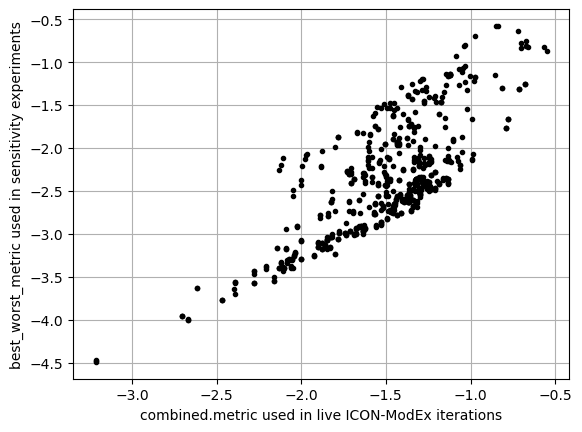

In [8]:
# Out of curiousity, how does the older "combined.metric" compare to the "best_worst_metric" developed here?
fig, ax = plt.subplots(1,1)

ax.plot(np.log10(obs_df['combined.metric_avg']),np.log10(obs_df['best_worst_metric']),'k.')
ax.grid()
plt.xlabel('combined.metric used in live ICON-ModEx iterations')
plt.ylabel('best_worst_metric used in sensitivity experiments')

Looks like there is a reasonable relationship between the two, so I don't expect the results to change that much if we pick the 100|200|300 best and worst, etc.

Save the sorted data frame here (all points) so it can be sliced and diced as needed. For example, to grab the 100 worst and best points, use `head` and `tail`:
```
head -100 best_and_worst_sites_Nov-2023-log10-DO-update-correct.csv > worst.csv
tail -100 best_and_worst_sites_Nov-2023-log10-DO-update-correct.csv > best.csv
```

In [9]:
# Reset the index to Sample_ID so that this is the first column
# in the csv file when it is written. When 100|200|300 subsets
# are taken, it is only the first column that is read by
# make_input_data.py
obs_df.set_index('Sample_ID',inplace=True)

In [10]:
# Overwrite any existing file
obs_df.to_csv('best_and_worst_sites_Nov-2023-log10-DO-update-correct.csv', mode='w')